In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
from utils_unet_resunet import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model.models import Model_3
from model.losses import WBCE
from model.callbacks import UpdateWeights
from multiprocessing.pool import Pool

root_path = 'imgs/' 

In [3]:
# Define data type 
img_type = 'FUSION'

if img_type == 'FUSION':
    image_array = np.load(root_path+'New_Images/fus_stack.npy')
    

if img_type == 'OPT':
    image_array = np.load(root_path+'New_Images/opt_stack.npy')
    
    
if img_type == 'SAR':
    image_array = np.load(root_path+'New_Images/sar_stack.npy')
print('Image stack:', image_array.shape)

final_mask1 = np.load(root_path+'New_Images/'+'final_mask1.npy')
print('Labels stack:', final_mask1.shape)

h_, w_, channels = image_array.shape
n_opt_layers = 20

Image stack: (10000, 7000, 24)
Labels stack: (10000, 7000)


In [4]:
# Create tile mask
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
#plt.imshow(mask_tiles)

Tiles size:  2000 1750
Mask size:  (10000, 7000)
mask:  (10000, 7000)
image stack:  (10000, 7000, 24)
ref : (10000, 7000)


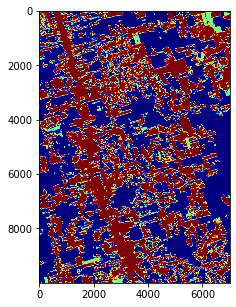

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

In [6]:
# Define tiles for training, validation, and test sets
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

In [7]:
# Create ixd image to extract patches
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [8]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   17110 Number of validation patches 4116


In [9]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(1158, 128, 128) (341, 128, 128)


In [10]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, batch_y = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = tf.keras.utils.to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)


In [11]:
exp = 3
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [12]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'unet'
if method == 'unet':
   model = build_unet(input_shape, nb_filters, number_class)

if method == 'resunet':
   model = build_resunet(input_shape, nb_filters, number_class)

model = Model_3(nb_filters, number_class, n_opt_layers)

In [13]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-4 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
#loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [15]:
metrics_all = []
times=5
for tm in range(0,times):
    print('time: ', tm)

    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-4 , beta_1=0.9)
    
    loss = weighted_categorical_crossentropy(weights)
    #loss = WBCE(weights = weights)
    #loss = WBCE(weights = weights, class_indexes = [0, 1])

    #if method == 'unet':
    #   model = build_unet(input_shape, nb_filters, number_class)

    #if method == 'resunet':
    #   model = build_resunet(input_shape, nb_filters, number_class)
    
    model = Model_3(nb_filters, number_class, n_opt_layers)
    model.build((None,)+input_shape)
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_sar_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min') ---- val_accuracy
    #checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_sar_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
    updateWeights = UpdateWeights()
    callbacks_list = [earlystop, checkpoint, updateWeights]
    # train the model
    start_training = time.time()
    history = model.fit(train_gen_crops,
                              steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                              validation_data=valid_gen_crops,
                              validation_steps=len(X_valid)*3//valid_gen.batch_size,
                              epochs=100,
                              callbacks=callbacks_list)
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

time:  0
Model: "model_3_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  332000    
_________________________________________________________________
opt_classifier (Classifier)  multiple                  195       
_________________________________________________________________
sar_classifier (Classifier)  multiple                  195       
_________________________________________________________________
fus_classifier (Classifier)  multiple                  195       
_________________________________________________________________
combination (CombinationLaye multiple           

108/108 [==============================] - 11s 107ms/step - opt_accuracy: 0.5841 - sar_accuracy: 0.8522 - fus_accuracy: 0.6177 - opt_loss: 0.1682 - sar_loss: 0.0803 - fusion_loss: 0.2798 - loss: 0.5283 - val_opt_accuracy: 0.5865 - val_sar_accuracy: 0.8061 - val_fus_accuracy: 0.6074 - val_opt_loss: 0.1523 - val_sar_loss: 0.1193 - val_fusion_loss: 0.2845 - val_loss: 0.5561

Epoch 00016: val_sar_loss did not improve from 0.11081
Epoch 00016: early stopping
time:  1
Model: "model_3_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
shared_decoder (UNET_Decoder multiple                  332000    
____________________________________________________

108/108 [==============================] - 13s 121ms/step - opt_accuracy: 0.5934 - sar_accuracy: 0.8530 - fus_accuracy: 0.6447 - opt_loss: 0.2037 - sar_loss: 0.0790 - fusion_loss: 0.2125 - loss: 0.4952 - val_opt_accuracy: 0.5975 - val_sar_accuracy: 0.8115 - val_fus_accuracy: 0.6051 - val_opt_loss: 0.1992 - val_sar_loss: 0.1398 - val_fusion_loss: 0.2375 - val_loss: 0.5765

Epoch 00015: val_sar_loss did not improve from 0.11265
Epoch 16/100
108/108 [==============================] - 13s 122ms/step - opt_accuracy: 0.5960 - sar_accuracy: 0.8550 - fus_accuracy: 0.6409 - opt_loss: 0.2037 - sar_loss: 0.0776 - fusion_loss: 0.2164 - loss: 0.4976 - val_opt_accuracy: 0.5928 - val_sar_accuracy: 0.8104 - val_fus_accuracy: 0.6029 - val_opt_loss: 0.2018 - val_sar_loss: 0.1304 - val_fusion_loss: 0.2369 - val_loss: 0.5692

Epoch 00016: val_sar_loss did not improve from 0.11265
Epoch 17/100
108/108 [==============================] - 14s 129ms/step - opt_accuracy: 0.5836 - sar_accuracy: 0.8585 - fus_accu

108/108 [==============================] - 14s 135ms/step - opt_accuracy: 0.4185 - sar_accuracy: 0.8281 - fus_accuracy: 0.4346 - opt_loss: 0.4034 - sar_loss: 0.0957 - fusion_loss: 0.4265 - loss: 0.9256 - val_opt_accuracy: 0.3925 - val_sar_accuracy: 0.8103 - val_fus_accuracy: 0.4317 - val_opt_loss: 0.4312 - val_sar_loss: 0.1173 - val_fusion_loss: 0.4214 - val_loss: 0.9699

Epoch 00006: val_sar_loss did not improve from 0.11360
Epoch 7/100
108/108 [==============================] - 15s 136ms/step - opt_accuracy: 0.4191 - sar_accuracy: 0.8339 - fus_accuracy: 0.4422 - opt_loss: 0.4241 - sar_loss: 0.0938 - fusion_loss: 0.4132 - loss: 0.9310 - val_opt_accuracy: 0.3911 - val_sar_accuracy: 0.8052 - val_fus_accuracy: 0.4571 - val_opt_loss: 0.4487 - val_sar_loss: 0.1172 - val_fusion_loss: 0.3804 - val_loss: 0.9464

Epoch 00007: val_sar_loss did not improve from 0.11360
Epoch 8/100
108/108 [==============================] - 15s 138ms/step - opt_accuracy: 0.4187 - sar_accuracy: 0.8375 - fus_accura

Epoch 1/100
108/108 [==============================] - 21s 174ms/step - opt_accuracy: 0.5978 - sar_accuracy: 0.7594 - fus_accuracy: 0.6205 - opt_loss: 0.2133 - sar_loss: 0.1348 - fusion_loss: 0.2012 - loss: 0.5494 - val_opt_accuracy: 0.5617 - val_sar_accuracy: 0.7720 - val_fus_accuracy: 0.6275 - val_opt_loss: 0.2372 - val_sar_loss: 0.1257 - val_fusion_loss: 0.2024 - val_loss: 0.5653

Epoch 00001: val_sar_loss improved from inf to 0.12570, saving model to imgs/experiments/exp3/models\unet_3.h5
Epoch 2/100
108/108 [==============================] - 18s 168ms/step - opt_accuracy: 0.5726 - sar_accuracy: 0.8007 - fus_accuracy: 0.6514 - opt_loss: 0.2366 - sar_loss: 0.1155 - fusion_loss: 0.1933 - loss: 0.5454 - val_opt_accuracy: 0.5444 - val_sar_accuracy: 0.7888 - val_fus_accuracy: 0.6693 - val_opt_loss: 0.2715 - val_sar_loss: 0.1319 - val_fusion_loss: 0.1692 - val_loss: 0.5726

Epoch 00002: val_sar_loss did not improve from 0.12570
Epoch 3/100
108/108 [==============================] - 18s 1


Epoch 00018: val_sar_loss did not improve from 0.11085
Epoch 19/100
108/108 [==============================] - 23s 213ms/step - opt_accuracy: 0.5201 - sar_accuracy: 0.8577 - fus_accuracy: 0.6449 - opt_loss: 0.2559 - sar_loss: 0.0745 - fusion_loss: 0.1952 - loss: 0.5256 - val_opt_accuracy: 0.5134 - val_sar_accuracy: 0.8128 - val_fus_accuracy: 0.6374 - val_opt_loss: 0.2683 - val_sar_loss: 0.1372 - val_fusion_loss: 0.1957 - val_loss: 0.6013

Epoch 00019: val_sar_loss did not improve from 0.11085
Epoch 20/100
108/108 [==============================] - 22s 205ms/step - opt_accuracy: 0.5220 - sar_accuracy: 0.8595 - fus_accuracy: 0.6393 - opt_loss: 0.2579 - sar_loss: 0.0732 - fusion_loss: 0.1985 - loss: 0.5296 - val_opt_accuracy: 0.5120 - val_sar_accuracy: 0.8141 - val_fus_accuracy: 0.6293 - val_opt_loss: 0.2715 - val_sar_loss: 0.1194 - val_fusion_loss: 0.1994 - val_loss: 0.5903

Epoch 00020: val_sar_loss did not improve from 0.11085
Epoch 21/100
108/108 [==============================] - 23

108/108 [==============================] - 25s 236ms/step - opt_accuracy: 0.5195 - sar_accuracy: 0.8475 - fus_accuracy: 0.6098 - opt_loss: 0.2626 - sar_loss: 0.0841 - fusion_loss: 0.1968 - loss: 0.5435 - val_opt_accuracy: 0.4893 - val_sar_accuracy: 0.8067 - val_fus_accuracy: 0.6225 - val_opt_loss: 0.2745 - val_sar_loss: 0.1152 - val_fusion_loss: 0.1574 - val_loss: 0.5471

Epoch 00013: val_sar_loss did not improve from 0.11001
Epoch 14/100
108/108 [==============================] - 25s 231ms/step - opt_accuracy: 0.5000 - sar_accuracy: 0.8487 - fus_accuracy: 0.6118 - opt_loss: 0.2752 - sar_loss: 0.0814 - fusion_loss: 0.1978 - loss: 0.5543 - val_opt_accuracy: 0.5037 - val_sar_accuracy: 0.8087 - val_fus_accuracy: 0.6099 - val_opt_loss: 0.2734 - val_sar_loss: 0.1250 - val_fusion_loss: 0.1889 - val_loss: 0.5873

Epoch 00014: val_sar_loss did not improve from 0.11001
Epoch 15/100
108/108 [==============================] - 26s 239ms/step - opt_accuracy: 0.4986 - sar_accuracy: 0.8519 - fus_accu

In [16]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

#if method == 'unet':
#   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

new_model = Model_3(nb_filters, number_class, n_opt_layers)
new_model.build((None,)+input_shape)
adam = Adam(lr = 1e-4 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
new_model.compile(optimizer=adam, loss=loss, metrics=['accuracy'], run_eagerly=True)

for tm in range(0,times):
    print('time: ', tm)
    #model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    #for l in range(1, len(model.layers)):
    #    new_model.layers[l].set_weights(model.layers[l].get_weights())
    new_model.load_weights(path_models+ '/' + method +'_'+str(tm)+'.h5')
    
    start_test = time.time()
    patch_opt = []
    patch_sar = []
    patch_fus = []
    patch_comb = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            pred_opt, pred_sar, pred_fus, pred_comb = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_opt.append(pred_opt[:,:,:,1])
            patch_sar.append(pred_sar[:,:,:,1])
            patch_fus.append(pred_fus[:,:,:,1])
            patch_comb.append(pred_comb[:,:,:,1])
            del pred_opt, pred_sar, pred_fus, pred_comb
    end_test =  time.time() - start_test

    patches_pred_opt = np.asarray(patch_opt).astype(np.float32)
    patches_pred_sar = np.asarray(patch_sar).astype(np.float32)
    patches_pred_fus = np.asarray(patch_fus).astype(np.float32)
    patches_pred_comb = np.asarray(patch_comb).astype(np.float32)

    prob_recontructed_opt = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_opt)
    prob_recontructed_sar = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_sar)
    prob_recontructed_fus = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_fus)
    prob_recontructed_comb = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_comb)

    del patches_pred_opt, patches_pred_sar, patches_pred_fus, patches_pred_comb
    np.save(path_maps+'/'+'prob_opt_'+str(tm)+'.npy',prob_recontructed_opt) 
    np.save(path_maps+'/'+'prob_sar_'+str(tm)+'.npy',prob_recontructed_sar) 
    np.save(path_maps+'/'+'prob_fus_'+str(tm)+'.npy',prob_recontructed_fus) 
    np.save(path_maps+'/'+'prob_comb_'+str(tm)+'.npy',prob_recontructed_comb) 

    time_ts.append(end_test)
    del prob_recontructed_opt, prob_recontructed_sar, prob_recontructed_fus, prob_recontructed_comb
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)


0.0 -8.0
time:  0
time:  1
time:  2
time:  3
time:  4


In [17]:
# Compute mean of the tm predictions maps
prob_rec_opt = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_sar = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_fus = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_comb = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec_opt[:,:,tm] = np.load(path_maps+'/'+'prob_opt_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_sar[:,:,tm] = np.load(path_maps+'/'+'prob_sar_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_fus[:,:,tm] = np.load(path_maps+'/'+'prob_fus_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_comb[:,:,tm] = np.load(path_maps+'/'+'prob_comb_'+str(tm)+'.npy').astype(np.float32)

mean_prob_opt = np.mean(prob_rec_opt, axis = -1)
mean_prob_sar = np.mean(prob_rec_sar, axis = -1)
mean_prob_fus = np.mean(prob_rec_fus, axis = -1)
mean_prob_comb = np.mean(prob_rec_comb, axis = -1)

np.save(path_maps+'/prob_mean_opt.npy', mean_prob_opt)
np.save(path_maps+'/prob_mean_sar.npy', mean_prob_sar)
np.save(path_maps+'/prob_mean_fus.npy', mean_prob_fus)
np.save(path_maps+'/prob_mean_comb.npy', mean_prob_comb)

0
1
2
3
4


(-0.5, 6999.5, 9999.5, -0.5)

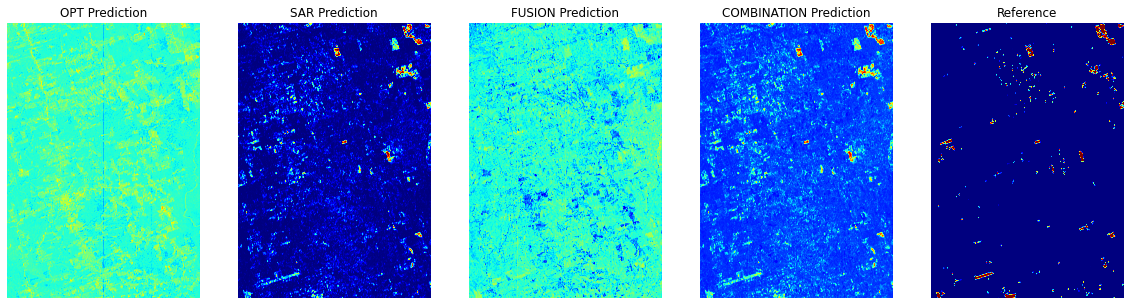

In [18]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(151)
plt.title('OPT Prediction')
ax1.imshow(mean_prob_opt, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(152)
plt.title('SAR Prediction')
ax1.imshow(mean_prob_sar, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(153)
plt.title('FUSION Prediction')
ax1.imshow(mean_prob_fus, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(154)
plt.title('COMBINATION Prediction')
ax1.imshow(mean_prob_comb, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(155)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [19]:
# Computing metrics
mean_prob_opt = mean_prob_opt[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_sar = mean_prob_sar[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_fus = mean_prob_fus[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_comb = mean_prob_comb[:final_mask1.shape[0], :final_mask1.shape[1]]

ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 10

Pmax_opt = np.max(mean_prob_opt[GTTruePositives * TileMask ==1])
ProbList_opt = np.linspace(Pmax_opt,0,Npoints)

Pmax_sar = np.max(mean_prob_sar[GTTruePositives * TileMask ==1])
ProbList_sar = np.linspace(Pmax_sar,0,Npoints)

Pmax_fus = np.max(mean_prob_fus[GTTruePositives * TileMask ==1])
ProbList_fus = np.linspace(Pmax_fus,0,Npoints)

Pmax_comb = np.max(mean_prob_comb[GTTruePositives * TileMask ==1])
ProbList_comb = np.linspace(Pmax_comb,0,Npoints)


from multiprocessing.pool import Pool
pool = Pool(processes=4)

#async_result_opt = pool.apply_async(matrics_AA_recall, (ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625))
async_result_sar = pool.apply_async(matrics_AA_recall, (ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625))
#async_result_fus = pool.apply_async(matrics_AA_recall, (ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625))
#async_result_comb = pool.apply_async(matrics_AA_recall, (ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625))

#metrics_opt = async_result_opt.get()
metrics_sar = async_result_sar.get()
#metrics_fus = async_result_fus.get()
#metrics_comb = async_result_comb.get()
    
#metrics_opt = matrics_AA_recall(ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625)
#metrics_sar = matrics_AA_recall(ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625)
#metrics_fus = matrics_AA_recall(ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625)
#metrics_comb = matrics_AA_recall(ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625)

#np.save(path_exp+'/acc_metrics_opt.npy',metrics_opt)
np.save(path_exp+'/acc_metrics_sar.npy',metrics_sar)
#np.save(path_exp+'/acc_metrics_fus.npy',metrics_fus)
#np.save(path_exp+'/acc_metrics_comb.npy',metrics_comb)

In [20]:
# Complete NaN values
#metrics_copy_opt = metrics_opt.copy()
#metrics_copy_opt = complete_nan_values(metrics_copy_opt)

metrics_copy_sar = metrics_sar.copy()
metrics_copy_sar = complete_nan_values(metrics_copy_sar)

#metrics_copy_fus = metrics_fus.copy()
#metrics_copy_fus = complete_nan_values(metrics_copy_fus)

#metrics_copy_comb = metrics_comb.copy()
#metrics_copy_comb = complete_nan_values(metrics_copy_comb)

SAR mAP 0.8517279414918357


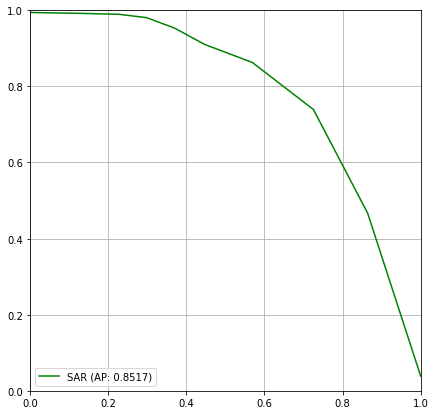

In [21]:
# Comput Mean Average Precision (mAP) score 
#Recall_opt = metrics_copy_opt[:,0]
#Precision_opt = metrics_copy_opt[:,1]
#AA_opt = metrics_copy_opt[:,2]

Recall_sar = metrics_copy_sar[:,0]
Precision_sar = metrics_copy_sar[:,1]
AA_sar = metrics_copy_sar[:,2]

#Recall_fus = metrics_copy_fus[:,0]
#Precision_fus = metrics_copy_fus[:,1]
#AA_fus = metrics_copy_fus[:,2]

#Recall_comb = metrics_copy_comb[:,0]
#Precision_comb = metrics_copy_comb[:,1]
#AA_comb = metrics_copy_comb[:,2]
    
#DeltaR_opt = Recall_opt[1:]-Recall_opt[:-1]
#AP_opt = np.sum(Precision_opt[:-1]*DeltaR_opt)
#print('OPT mAP', AP_opt)

DeltaR_sar = Recall_sar[1:]-Recall_sar[:-1]
AP_sar = np.sum(Precision_sar[:-1]*DeltaR_sar)
print('SAR mAP', AP_sar)

#DeltaR_fus = Recall_fus[1:]-Recall_fus[:-1]
#AP_fus = np.sum(Precision_fus[:-1]*DeltaR_fus)
#print('FUSION mAP', AP_fus)

#DeltaR_comb = Recall_comb[1:]-Recall_comb[:-1]
#AP_comb = np.sum(Precision_comb[:-1]*DeltaR_comb)
#print('COMBINATION mAP', AP_comb)

# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
#plt.plot(metrics_copy_opt[:,0],metrics_copy_opt[:,1], 'r-', label = f'OPT (AP: {AP_opt:.4f})')
plt.plot(metrics_copy_sar[:,0],metrics_copy_sar[:,1], 'g-', label = f'SAR (AP: {AP_sar:.4f})')
#plt.plot(metrics_copy_fus[:,0],metrics_copy_fus[:,1], 'b-', label = f'FUSION (AP: {AP_fus:.4f})')
#plt.plot(metrics_copy_comb[:,0],metrics_copy_comb[:,1], 'k-', label = f'COMBINATION (AP: {AP_comb:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()